This notebook runs inference for a bayesian regression on the bodyfat data.
Data preprocessing:

- demean all columns

- drop undwater density (expensive to measure -- idea of this exercise is, I guess, do have cheaper ways of measuring bodyfat) 

- Put prior: Normal(0,1) on all covariates, Normal(0, 2) on the error (we kind of know it's 0 since we demeaned the data, so that might have been a stupid prior to put), HalfCauchy(scale 1) on sigma.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.distributions as dist
import pyro
import pyro.distributions as pyro_dist
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean, AutoNormal
from pyro.infer import SVI, Trace_ELBO

import bayesreg_pyro as br

In [3]:
data = pd.read_csv("bodyfat.csv").drop("Density", axis=1)
data = data - data.mean()
data.head(3)

,Bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,-6.850794,-21.884921,-24.674405,-2.39881,-1.792063,-7.724206,-7.355952,-5.404762,-0.405952,-1.290476,-1.202381,-0.273413,-1.263889,-1.129762
1,-13.050794,-22.884921,-5.674405,2.10119,0.507937,-7.224206,-9.555952,-1.204762,-0.705952,-1.290476,0.297619,-1.773413,0.236111,-0.029762
2,6.149206,-22.884921,-24.924405,-3.89881,-3.992063,-5.024206,-4.655952,-0.704762,0.194048,0.309524,0.897619,-3.473413,-3.463889,-1.629762


In [4]:
# sns.pairplot(data)
# plt.show()

In [5]:
# prepare data
y_data = torch.Tensor(data["Bodyfat"].values)
x_data = torch.Tensor(data.drop("Bodyfat", axis=1).values)
in_features = x_data.shape[1]

In [11]:
model = br.BayesianRegression(in_features, 1)
guide = AutoDiagonalNormal(model) # Stochastic Mean field
adam = pyro.optim.Adam({"lr": 0.009})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [229]:
torch.manual_seed(12)
pyro.clear_param_store()
tic=time.time()
elbos = model.run_vi(x_data, y_data, svi, num_iterations=10000)
toc=time.time()
print(f"SVI time: {toc-tic} sec")
guide.requires_grad_(False)
samples, iw = br.sample_and_calculate_log_impweight(x_data, y_data, model, guide, num_post_samples=int(1e3))

SVI time: 21.306735277175903 sec


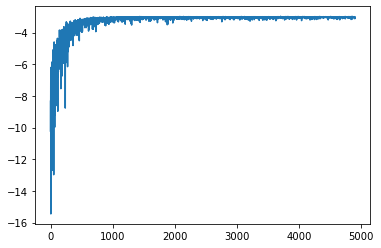

In [13]:
plt.plot(elbos[100:])
plt.show()

In [14]:
posterior_loc = pyro.param("AutoDiagonalNormal.loc").numpy().copy()
posterior_scale = pyro.param("AutoDiagonalNormal.scale").numpy().copy()

# swap the sigma and the bias
# posterior_loc[0], posterior_loc[-1] = posterior_loc[-1], posterior_loc[0]
# posterior_scale[0], posterior_scale[-1] = posterior_scale[-1], posterior_scale[0]

In [15]:
# VI results -- calculated from posterior samples
pd.DataFrame({
    "loc": posterior_loc,
    "scale": posterior_scale,
}, index=["log-sigma"] + list(data.drop("Bodyfat", axis=1).columns) + ["Intercept"]).pipe(lambda df: np.round(df, 4))


,loc,scale
log-sigma,1.4607,0.0520
Age,0.0563,0.0273
Weight,-0.0950,0.0140
Height,-0.0735,0.0757
Neck,-0.4899,0.1137
Chest,-0.0243,0.0344
Abdomen,0.9509,0.0296
Hip,-0.2135,0.0434
Thigh,0.2387,0.0536
Knee,0.0005,0.1163


In [16]:
torch.manual_seed(21)
tic = time.time()
hmc_samples = br.run_hmc(x_data, y_data, model)
toc=time.time()
print(f"HMC time: {toc-tic} sec")

Sample: 100%|██████████| 1200/1200 [01:22, 14.55it/s, step size=1.30e-01, acc. prob=0.914]

HMC time: 82.46684312820435 sec


In [67]:
hmc_means

array([ 4.3150492e+00,  5.4038361e-02, -9.5218986e-02, -7.4607588e-02,
       -4.7373512e-01, -2.0161597e-02,  9.5714855e-01, -1.9621056e-01,
        2.3546845e-01,  1.0258518e-02,  1.2621512e-01,  1.6751717e-01,
        4.0801826e-01, -1.2765930e+00,  3.4237262e-03], dtype=float32)

In [77]:
# HMC results
hmc_means = np.append(
        hmc_samples["sigma"].mean(), 
        np.append(hmc_samples["linear.weight"].mean(axis=0), hmc_samples["linear.bias"].mean())
    )
hmc_means[0] = np.log(hmc_means[0])

pd.DataFrame({
    "loc": hmc_means, 
    "scale": np.append(
        np.log(hmc_samples["sigma"]).std(), 
        np.append(hmc_samples["linear.weight"].std(axis=0), hmc_samples["linear.bias"].std() )
    ),
}, index=["log-sigma"] + list(data.drop("Bodyfat", axis=1).columns) + ["Intercept"]).pipe(lambda df: np.round(df, 4))


,loc,scale
log-sigma,1.4621,0.0452
Age,0.0540,0.0325
Weight,-0.0952,0.0504
Height,-0.0746,0.0963
Neck,-0.4737,0.2175
Chest,-0.0202,0.0999
Abdomen,0.9571,0.0836
Hip,-0.1962,0.1438
Thigh,0.2355,0.1383
Knee,0.0103,0.2316


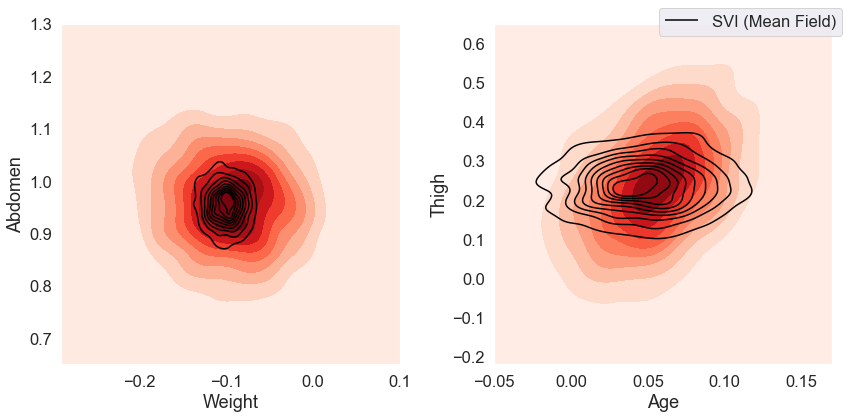

In [263]:
# compare HMC vs VI
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
#fig.suptitle("Posterior Distribution", fontsize=16)
sns.set(font_scale=1.5)

sns.kdeplot(
    x=hmc_samples["linear.weight"][:, 1], 
    y=hmc_samples["linear.weight"][:, 5], 
    ax=axs[0], shade=True, 
    fill=True, thresh=0.0, cmap=sns.color_palette("Reds", as_cmap=True))
sns.kdeplot(
    x=samples[:, 2], y=samples[:, 6], ax=axs[0], 
    label="SVI (Mean Field)",
    color="black"
)
axs[0].set(xlabel="Weight", ylabel="Abdomen", xlim=[-.29, .1], ylim=(0.65, 1.3))

sns.kdeplot(
    x=hmc_samples["linear.weight"][:, 0], 
    y=hmc_samples["linear.weight"][:,7], 
    ax=axs[1], 
    fill=True, thresh=0.0, cmap=sns.color_palette("Reds", as_cmap=True))
sns.kdeplot(
    x=samples[:, 1], 
    y=samples[:, 8], 
    ax=axs[1], 
    label="SVI (Mean Field)",
    color="black"
)
axs[1].set(xlabel="Age", ylabel="Thigh",  xlim=[-.05, .17], ylim=(-.22, 0.65))


handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()

In [264]:
fig.savefig("figs/MFVI_joint_example.pdf", bbox_inches='tight')

In [87]:
# Run non mean-field
torch.manual_seed(12)
pyro.clear_param_store()

guide_mvt = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
svi_mvt = SVI(model, guide_mvt, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

tic = time.time()
elbos_mvt = model.run_vi(x_data, y_data, svi_mvt, num_iterations=4000)
toc=time.time()
guide_mvt.requires_grad_(False)
samples_mvt, iw_mvt = br.sample_and_calculate_log_impweight(x_data, y_data, model, guide_mvt, num_post_samples=int(1e3))
print(f"Non-MFVI time: {toc-tic} sec")

Non-MFVI time: 9.013319969177246 sec


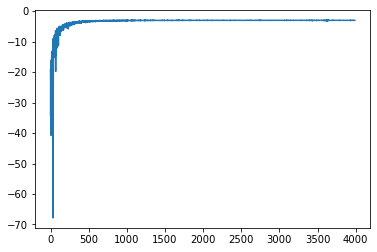

In [88]:
plt.plot(elbos_mvt[10:])
plt.show()

In [90]:
# non-mean field VI results
# use samples for loc and scale this time (alternatively, use pyro.param("AutoMultivariateNormal")...)
print("--- Non-mean field parameter estimates ---")
np.round(pd.DataFrame({
    "loc": guide_mvt.get_posterior().mean,
    "scale": guide_mvt.get_posterior().stddev,
}, index=["sigma"] + list(data.drop("Bodyfat", axis=1).columns) + ["Intercept"]), 4)


--- Non-mean field parameter estimates ---


,loc,scale
sigma,1.4704,0.0543
Age,0.0570,0.0347
Weight,-0.0985,0.0683
Height,-0.0877,0.1086
Neck,-0.4913,0.2352
Chest,-0.0200,0.1135
Abdomen,0.9382,0.0943
Hip,-0.1790,0.1711
Thigh,0.2228,0.1383
Knee,0.0192,0.2303


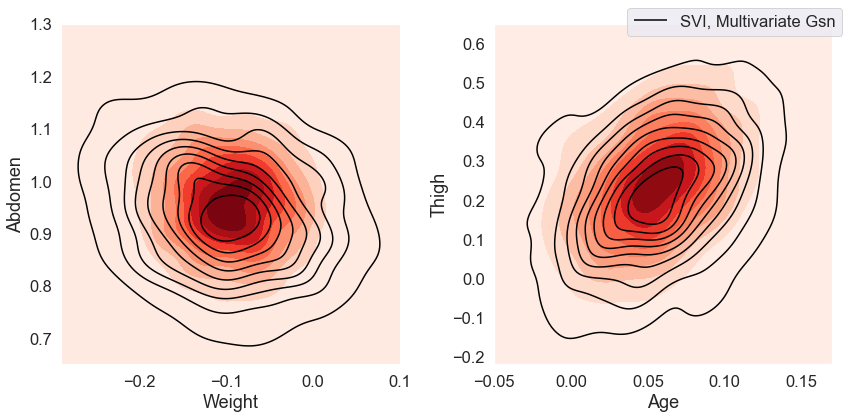

In [265]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
#fig.suptitle("Posterior Distribution", fontsize=16)

sns.kdeplot(
    x=hmc_samples["linear.weight"][:, 1], 
    y=hmc_samples["linear.weight"][:, 5], 
    ax=axs[0], shade=True, 
    fill=True, thresh=0.0, cmap=sns.color_palette("Reds", as_cmap=True))
sns.kdeplot(
    x=samples_mvt[:, 2], y=samples_mvt[:, 6], ax=axs[0], 
    label="SVI (Mean Field)",
    color="black", #levels=8,
)
axs[0].set(xlabel="Weight", ylabel="Abdomen", xlim=[-.29, .1], ylim=(0.65, 1.3))


sns.kdeplot(
    x=hmc_samples["linear.weight"][:, 0], 
    y=hmc_samples["linear.weight"][:,7], 
    ax=axs[1], 
    fill=True, thresh=0.0, cmap=sns.color_palette("Reds", as_cmap=True),
)
sns.kdeplot(
    x=samples_mvt[:, 1], y=samples_mvt[:, 8], ax=axs[1], label="SVI, Multivariate Gsn",
    color="black"
)
axs[1].set(xlabel="Age", ylabel="Thigh", xlim=[-.05, .17], ylim=(-.22, 0.65))


handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()

In [266]:
fig.savefig("figs/MVNVI_joint_example.pdf", bbox_inches='tight')

----------------------

Run VI multiple times to produce the density charts;

Note this can take a while 5-10min.

----------------------

In [92]:
## seems like the sigmas are mostly off
sigma_MF, sigma_MVT, sigma_HMC = np.exp(samples[:, 0]), np.exp(samples_mvt[:, 0]), hmc_samples["sigma"].reshape(-1, )

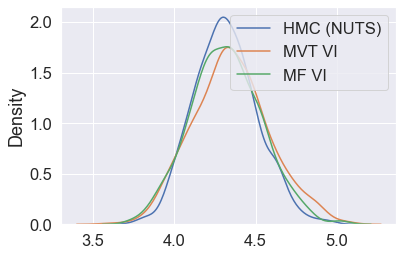

In [267]:
sns.kdeplot(x=sigma_HMC, label="HMC (NUTS)")
sns.kdeplot(x=sigma_MVT, label="MVT VI")
sns.kdeplot(x=sigma_MF, label="MF VI")
plt.legend()
plt.show()


In [275]:
# check the estimate of sigma on average of 20 VI runs:
pyro.clear_param_store()
n_runs=20
post_samples = 1000
params = torch.zeros(n_runs, 15)
samples = torch.zeros((n_runs, post_samples, 15))
torch.manual_seed(4200) #420

for i in range(n_runs):
    g = AutoDiagonalNormal(model) #AutoMultivariateNormal
    svi = SVI(model, g, pyro.optim.Adam({"lr": 0.009}), loss=Trace_ELBO())
    print(".-", end="")
    elbos_mvt = model.run_vi(x_data, y_data, svi, num_iterations=6000)
    g.requires_grad_(False)
    params[i, :] = g.get_posterior().mean
    samples[i] = g.get_posterior().sample((post_samples,))
    pyro.clear_param_store()


.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-

In [276]:
colnames=index=["log_sigma"] + list(data.drop("Bodyfat", axis=1).columns) + ["Intercept"]


In [277]:
#pd.DataFrame(x) 
dict_samples = dict(zip(colnames, [pd.DataFrame(samples[:,:,i].numpy().T) for i in range(15)]))
def helper(key, val):
    val["parameter"] = key
    return val
df_samples = pd.concat([helper(key, val) for key, val in dict_samples.items()])

In [278]:
df_hmc = pd.DataFrame(hmc_samples["linear.weight"], columns=list(data.drop("Bodyfat", axis=1).columns))
df_hmc["log_sigma"] = np.log(hmc_samples["sigma"])
df_hmc["Intercept"] = hmc_samples["linear.bias"]

In [279]:
df_samples_means = pd.DataFrame(params.numpy().T)
df_samples_means["HMC"] = hmc_means
df_samples_means.index=colnames
df_samples_means = df_samples_means.T

In [280]:
# there are then read into r for the density charts
df_samples.to_csv("MF_df_samples.csv")
df_hmc.to_csv("MF_df_hmc.csv")
# df_samples_means.to_csv("MF_df_samples_means.csv")